In [77]:
import numpy as np 
import pickle
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# get residuals
avg_residual_file_layer1 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer1-avg.p"
avg_residual_file_layer2 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer2-avg.p"

max_residual_file_layer1 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer1-max.p"
max_residual_file_layer2 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer2-max.p"

min_residual_file_layer1 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer1-min.p"
min_residual_file_layer2 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer2-min.p"

last_residual_file_layer1 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer1-last.p"
last_residual_file_layer2 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer2-last.p"

# open files
avg_residual_layer1 = pickle.load( open( avg_residual_file_layer1, "rb" ) )
avg_residual_layer2 = pickle.load( open( avg_residual_file_layer2, "rb" ) )

max_residual_layer1 = pickle.load( open( max_residual_file_layer1, "rb" ) )
max_residual_layer2 = pickle.load( open( max_residual_file_layer2, "rb" ) )

min_residual_layer1 = pickle.load( open( min_residual_file_layer1, "rb" ) )
min_residual_layer2 = pickle.load( open( min_residual_file_layer2, "rb" ) )

last_residual_layer1 = pickle.load( open( last_residual_file_layer1, "rb" ) )
last_residual_layer2 = pickle.load( open( last_residual_file_layer2, "rb" ) )

In [4]:
def clean_roi(roi_vals, roi_labels):
    roi_vals = roi_vals.reshape((len(roi_vals), ))
    final_roi_labels = []
    for val_index in roi_vals:
        if val_index == 0:
            final_roi_labels.append("other")
        else:
            final_roi_labels.append(roi_labels[val_index-1][0][0])
    return final_roi_labels

def clean_atlas(atlas_vals, atlas_labels):
    at_vals = atlas_vals.reshape((len(atlas_vals), ))
    at_labels = []
    for val_index in at_vals:
        at_labels.append(atlas_labels[val_index-1][0][0])
    return at_labels

In [5]:
# get atlas and roi
atlas_vals = pickle.load( open( "atlas_vals.p", "rb" ) )
atlas_labels = pickle.load( open( "atlas_labels.p", "rb" ) )
roi_vals = pickle.load( open( "roi_vals.p", "rb" ) )
roi_labels = pickle.load( open( "roi_labels.p", "rb" ) )

final_roi_labels = clean_roi(roi_vals, roi_labels)
at_labels = clean_atlas(atlas_vals, atlas_labels)

In [6]:
# get activations
activations = pickle.load( open( "activations.p", "rb" ) )
modified_activations = pickle.load( open( "modified_activations.p", "rb" ) )

In [7]:
df_dict = {'voxel_index': list(range(len(at_labels))) * 8, 
            'residuals': avg_residual_layer1 + avg_residual_layer2 + max_residual_layer1 + max_residual_layer2 + min_residual_layer1 + min_residual_layer2 + last_residual_layer1 + last_residual_layer2, 
            'atlas_labels': at_labels * 8, 
            'roi_labels': final_roi_labels * 8,
            'agg_type': ['avg']*len(at_labels)*2 + ['max']*len(at_labels)*2 + ['min']*len(at_labels)*2 + ['last']*len(at_labels)*2,
            'layer': (['layer1']*len(at_labels) + ['layer2']*len(at_labels))*4 }

df = pd.DataFrame(df_dict)

In [12]:
df.head()

,agg_type,atlas_labels,layer,residuals,roi_labels,voxel_index
0,avg,Cerebelum_8_L,layer1,5.530148e-12,other,0
1,avg,Cerebelum_7b_L,layer1,5.547563e-12,other,1
2,avg,Cerebelum_8_R,layer1,5.181878e-12,other,2
3,avg,Cerebelum_8_L,layer1,5.271514e-12,other,3
4,avg,Cerebelum_8_L,layer1,5.446057e-12,other,4


In [10]:
pickle.dump( df, open( "subj1-2layer-4aggs.p", "wb" ) )

In [11]:
df.to_csv("subj1-2layer-4aggs.csv")

### Prepping for Permutation Testing

In [15]:
only_avg_layer1 = df[df['agg_type'] == 'avg'][df['layer'] == 'layer1']

/Users/christinejou/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [73]:
def get_shuffle(df):
    original = df[['atlas_labels','residuals']]
    permutate_values = original["residuals"].sample(frac=1)
    permutate = pd.DataFrame({'atlas_labels': original["atlas_labels"], 'residuals':list(permutate_values)})
    return original, permutate

In [66]:
def calculate_p_value(df1, df2):
    numerator = 0
    df1_values = list(df1["residuals"])
    df2_values = list(df2["residuals"])
    for i in range(len(df1_values)):
        if df1_values[i] < df2_values[i]:
            numerator += 1
    return numerator * 1.0 / len(df1_values)

In [79]:
p_values = []
for _ in tqdm(range(200)):
    original, permutate = get_shuffle(only_avg_layer1)
    p_val = calculate_p_value(permutate, original)
    p_values.append(p_val)

100%|██████████| 200/200 [00:17<00:00, 11.40it/s]


In [80]:
p_values

[0.49911072616316354,
 0.5014909386632462,
 0.500195045190979,
 0.49848922623258646,
 0.4992627952951133,
 0.5001752100868117,
 0.4995470984548454,
 0.4994942048437324,
 0.5002942207118157,
 0.5003735611284852,
 0.500366949427096,
 0.49996363564235985,
 0.4996330505729039,
 0.4994479229340086,
 0.5000033058506945,
 0.4994413112326195,
 0.5010281195660079,
 0.4990842793576071,
 0.5006710876909956,
 0.49959999206595834,
 0.5000892579687531,
 0.5003272792187614,
 0.4987735293923185,
 0.5017421833160327,
 0.5000760345659748,
 0.4994413112326195,
 0.4995735452604019,
 0.49938180592011744,
 0.5002148802951464,
 0.499857848420134,
 0.5005388536632132,
 0.4995074282465107,
 0.4997057792881842,
 0.49902477404510504,
 0.5004595132465437,
 0.49967272078123864,
 0.4999041303298578,
 0.5004925717534894,
 0.49961321546873655,
 0.5001289281770878,
 0.49942808782984127,
 0.4997256143923516,
 0.5008892738368365,
 0.4996264388715148,
 0.5000760345659748,
 0.4995470984548454,
 0.5009553908507276,
 0.4991

### Checking for certain brain region

In [84]:
original_cerebelum = original[original["atlas_labels"] == "Cerebelum_8_L"]
permutate_cerebelum = permutate[permutate["atlas_labels"] == "Cerebelum_8_L"]

In [85]:
calculate_p_value(original_cerebelum, permutate_cerebelum)

0.968384074941452

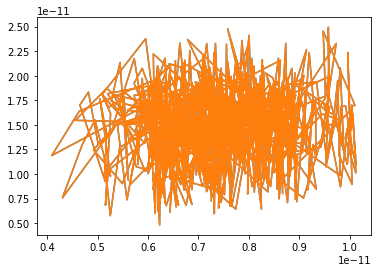

In [92]:
plt.plot(original_cerebelum["residuals"], permutate_cerebelum["residuals"])
plt.show()

In [88]:
original_cerebelum.head()

,atlas_labels,residuals
0,Cerebelum_8_L,5.530148e-12
3,Cerebelum_8_L,5.271514e-12
4,Cerebelum_8_L,5.446057e-12
5,Cerebelum_8_L,5.606933e-12
6,Cerebelum_8_L,5.526162e-12


In [89]:
permutate_cerebelum.head()

,atlas_labels,residuals
0,Cerebelum_8_L,1.664455e-11
3,Cerebelum_8_L,1.745652e-11
4,Cerebelum_8_L,2.135397e-11
5,Cerebelum_8_L,9.387570e-12
6,Cerebelum_8_L,1.782493e-11


### General Brain Areas

Original

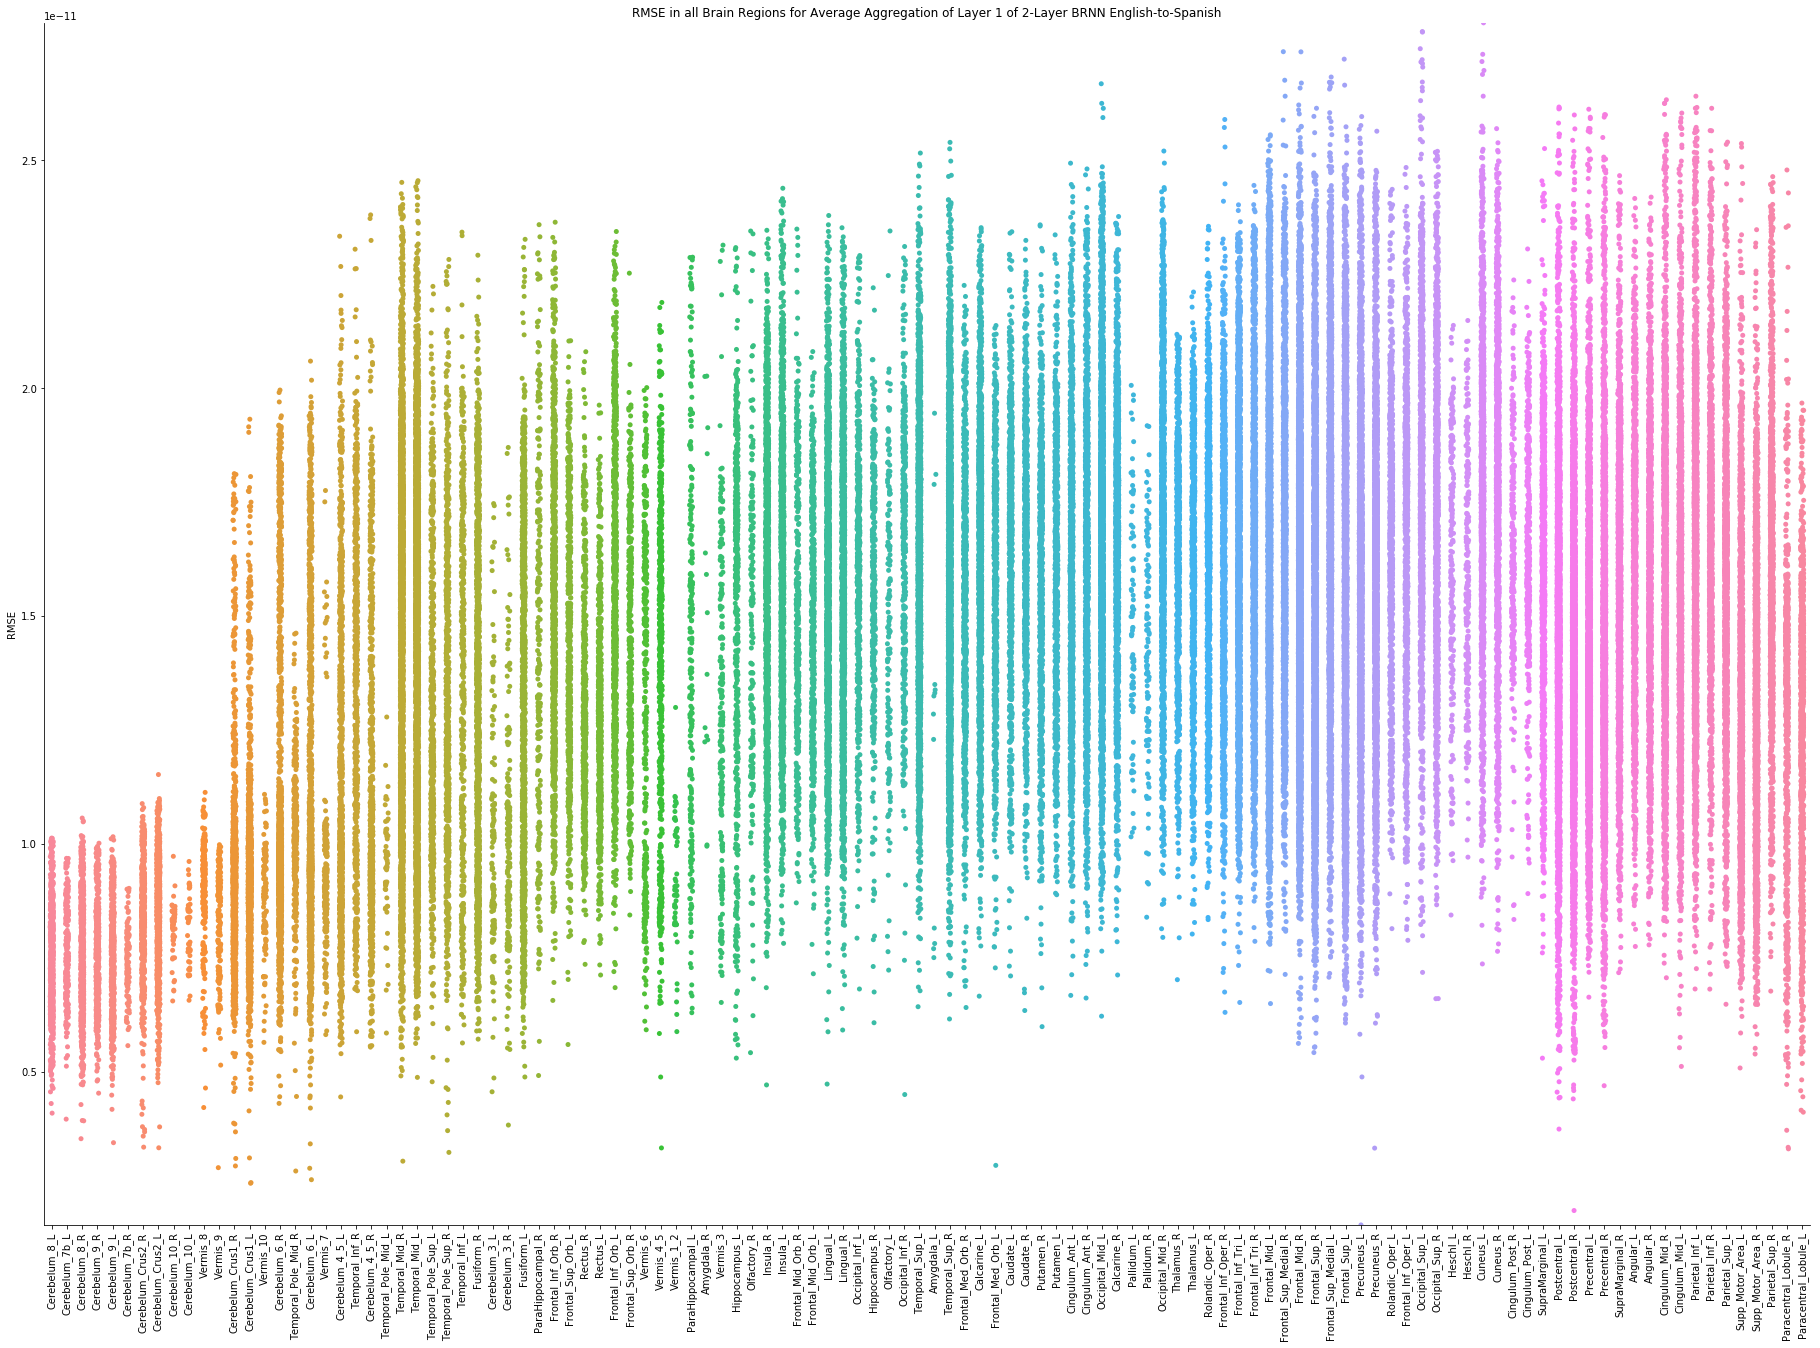

In [96]:
g = sns.catplot(x="atlas_labels", y="residuals", data=original, height=17.5, aspect=1.5)
g.set_xticklabels(rotation=90)
g.set(ylim=(min(original["residuals"]), max(original["residuals"])))
g.set_axis_labels("", "RMSE")
plt.title("RMSE in all Brain Regions for Average Aggregation of Layer 1 of 2-Layer BRNN English-to-Spanish")
plt.show()

Scrambled

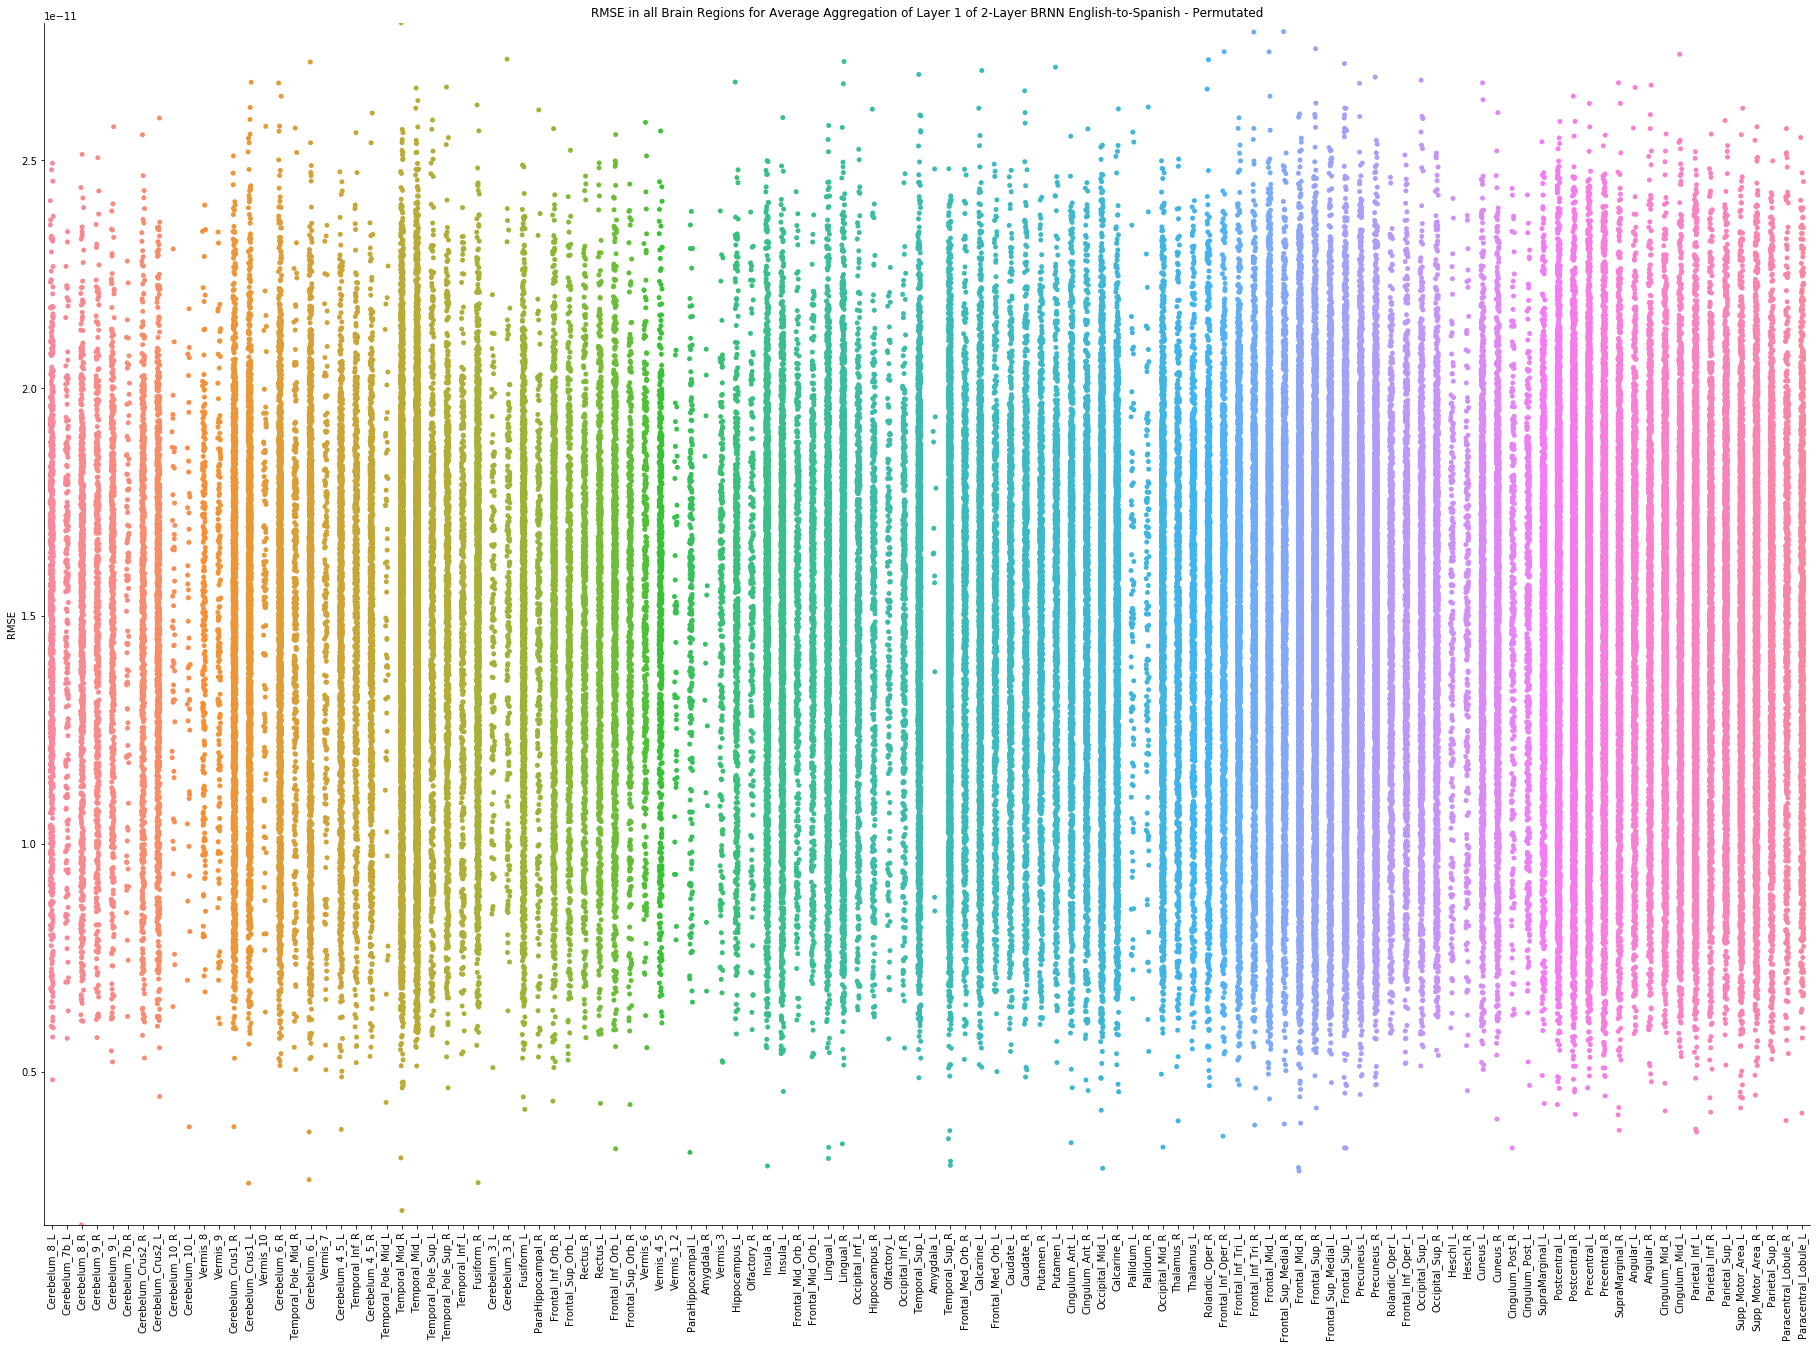

In [97]:
g = sns.catplot(x="atlas_labels", y="residuals", data=permutate, height=17.5, aspect=1.5)
g.set_xticklabels(rotation=90)
g.set(ylim=(min(permutate["residuals"]), max(permutate["residuals"])))
g.set_axis_labels("", "RMSE")
plt.title("RMSE in all Brain Regions for Average Aggregation of Layer 1 of 2-Layer BRNN English-to-Spanish - Permutated")
plt.show()

In [101]:
all_atlas_labels = list(set(list(original["atlas_labels"])))

In [118]:
len(all_atlas_labels)

116

In [ ]:
# p_values = []
# for _ in tqdm(range(200)):
#     original, permutate = get_shuffle(only_avg_layer1)
#     for atlas in all_atlas_labels:
#         original_sub = original[original['atlas_labels'] == atlas]
#         permutate_sub = permutate[permutate['atlas_labels'] == atlas]
#         p_val = calculate_p_value(permutate, original)
#         p_values.append(p_val)

In [116]:
p_values = {}
for _ in tqdm(range(200)):
    original, permutate = get_shuffle(only_avg_layer1)
    for atlas in all_atlas_labels:
        original_sub = original[original['atlas_labels'] == atlas]
        permutate_sub = permutate[permutate['atlas_labels'] == atlas]
        p_val = calculate_p_value(permutate_sub, original_sub)
        if atlas not in p_values:
            p_values[atlas]=[p_val]
        else:
            p_values[atlas].append(p_val)

100%|██████████| 200/200 [14:14<00:00,  4.25s/it]


In [117]:
p_values

{'Amygdala_L': [0.3076923076923077,
  0.3076923076923077,
  0.3076923076923077,
  0.3076923076923077,
  0.3076923076923077,
  0.46153846153846156,
  0.38461538461538464,
  0.23076923076923078,
  0.3076923076923077,
  0.38461538461538464,
  0.3076923076923077,
  0.23076923076923078,
  0.38461538461538464,
  0.3076923076923077,
  0.46153846153846156,
  0.3076923076923077,
  0.38461538461538464,
  0.5384615384615384,
  0.46153846153846156,
  0.3076923076923077,
  0.38461538461538464,
  0.3076923076923077,
  0.15384615384615385,
  0.46153846153846156,
  0.46153846153846156,
  0.38461538461538464,
  0.46153846153846156,
  0.3076923076923077,
  0.3076923076923077,
  0.15384615384615385,
  0.23076923076923078,
  0.23076923076923078,
  0.3076923076923077,
  0.15384615384615385,
  0.3076923076923077,
  0.3076923076923077,
  0.5384615384615384,
  0.23076923076923078,
  0.38461538461538464,
  0.46153846153846156,
  0.38461538461538464,
  0.23076923076923078,
  0.23076923076923078,
  0.30769230769

In [121]:
set(list(final_roi_labels))

{'LAngG',
 'LAntTemp',
 'LIFG',
 'LIFGorb',
 'LMFG',
 'LMidAntTemp',
 'LMidPostTemp',
 'LPostTemp',
 'other'}